# Equation solving tools

We distinguish between root finding or solving algebraic equations and solving differential equations.

It is also useful to distinguish between approximate solution using numeric methods and exact solution.

## Exact solution using sympy

We can solve systems of equations exactly using sympy's `solve` function. This is usually done using what is known as the residual form. The residual is simply the difference between the LHS and RHS of an equation, or put another way, we rewrite our equations to be equal to zero:

\begin{align}
x + y &= z \\
\therefore x + y - z &= 0
\end{align}

In [1]:
import sympy
sympy.init_printing()

In [2]:
x, y, z = sympy.symbols('x, y, z')

In [3]:
sympy.solve(x + y - z, z)

We can solve systems of equations using `solve` as well, by passing a list of equations

In [4]:
equations = [x + y - z, 
             2*x + y + z + 2,
             x - y - z + 2]
unknowns = [x, y, z]

In [5]:
solution = sympy.solve(equations, unknowns)
solution

In [6]:
%%timeit
sympy.solve(equations, unknowns)

8.54 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Notice that the result is a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries). We can get the individual answers by indexing (using [])

In [7]:
solution[x]

We often need the numeric value rather than the exact value. We can convert to a floating point number using `.n()`

In [8]:
solution[x].n()

## Special case: linear systems

For linear systems like the one above, we can solve very efficiently using matrix algebra. The system of equations can be rewritten in matrix form:

$$ A\mathbf{x} = \mathbf{b}$$

In [9]:
equations

In [10]:
A = sympy.Matrix([[1, 1, -1],
                  [2, 1, 1],
                  [1, -1, -1]])
b = sympy.Matrix([[0, -2, -2]]).T

In [11]:
A.solve(b)

⎡-4/3⎤
⎢    ⎥
⎢ 1  ⎥
⎢    ⎥
⎣-1/3⎦

In [12]:
%%time
A.solve(b)

CPU times: user 1.28 ms, sys: 6 µs, total: 1.29 ms
Wall time: 1.31 ms


⎡-4/3⎤
⎢    ⎥
⎢ 1  ⎥
⎢    ⎥
⎣-1/3⎦

We can repeat the solution using `numpy`. This is considerably faster than using `sympy` for large matrices.

In [13]:
import numpy

In [14]:
A = numpy.matrix([[1, 1, -1],
                  [2, 1, 1],
                  [1, -1, -1]])
b = numpy.matrix([[0, -2, -2]]).T

In [15]:
numpy.linalg.solve(A, b)

matrix([[-1.33333333],
        [ 1.        ],
        [-0.33333333]])

In [16]:
%%time
numpy.linalg.solve(A, b)

CPU times: user 276 µs, sys: 102 µs, total: 378 µs
Wall time: 318 µs


matrix([[-1.33333333],
        [ 1.        ],
        [-0.33333333]])

The numpy version is much faster, even for these small matrices. Let's try that again for a bigger matrix:

In [17]:
N = 30
bigA = numpy.random.random((N, N))

In [18]:
bigb = numpy.random.random((N,))

In [19]:
%%timeit
numpy.linalg.solve(bigA, bigb)

58 µs ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
bigsymbolicA = sympy.Matrix(bigA)

In [21]:
bigsimbolicb = sympy.Matrix(bigb)

In [22]:
%%timeit
bigsymbolicA.solve(bigsimbolicb)

1.15 s ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Wow! That takes about a million times longer.

## Nonlinear equations

In some cases, sympy can solve nonlinear equations exactly:

In [23]:
x, y = sympy.symbols('x, y')

In [24]:
sympy.solve([x + sympy.log(y), y**2 - 1], [x, y])

But sometimes nonlinear equations don't admit a closed-form solution:

In [25]:
unsolvable = x + sympy.cos(x) + sympy.log(x)
sympy.solve(unsolvable, x)

NotImplementedError: multiple generators [x, cos(x), log(x)]
No algorithms are implemented to solve equation x + log(x) + cos(x)

In such cases we need to use approximate (numeric) solutions.

In [27]:
import scipy.optimize

The function `sympy.lambdify` can be used to build a function which evaluates `sympy` expressions numerically:

In [28]:
unsolvable_numeric = sympy.lambdify(x, unsolvable)

In [29]:
unsolvable_numeric(50)

This is the kind of thing we can pass to `scipy.optimize.fsolve`

In [30]:
scipy.optimize.fsolve(unsolvable_numeric, 0.1)

array([0.28751828])

`fsolve` works for multiple equations as well, just return a list:

In [31]:
def multiple_equations(unknowns):
    x, y = unknowns
    return [x + y - 1,
            x - y]

In [32]:
multiple_equations([1, 2])

In [33]:
first_guess = [1, 1]
scipy.optimize.fsolve(multiple_equations, first_guess)

array([0.5, 0.5])

### Downsides of numerical solution

Remember the downsides of numerical solution:

1. Approximate rather than exact
2. Requires an initial guess
3. Slower to solve the equation every time rather than solving it once and then substituting values.
4. Typically only finds one solution, even if there are many.

## Differential equations

Now for differential equations.

We'll solve the "classic" tank problem:

![Tank system](../../assets/tanksystem.png)

\begin{align}
F_{out} &= kh\\
\frac{\mathrm{d}h}{\mathrm{d}t} &= \frac{1}{A}\left(F_{in} - F_{out}\right)\\
\end{align}

### Analytic solution
Sympy can solve some differential equations analytically:

In [34]:
h = sympy.Function('h')  # This is how to specify an unknown function in sympy
t = sympy.Symbol('t', positive=True)

In [35]:
Fin = 2
K = 1
A = 1

In [36]:
Fout = K*h(t)
Fout

We use `.diff()` to take the derivative of a function.

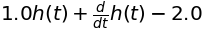

In [37]:
de = h(t).diff(t) - 1/A*(Fin - Fout)
de

Here we calculate the general solution. Notice this equation just satisfies the original differential equation when we plug it in, we don't have specific values at points in time until we specify boundary conditions.

In [38]:
solution = sympy.dsolve(de)
solution

We need a name for the constant of integration which Sympy created. Expressions are arranged as trees with the arguments as elements. We can navigate this tree to get the C1 element:

In [39]:
C1 = solution.rhs.args[1].args[0]

We can find the value of the constant by using an initial value:

In [40]:
h0 = 1

In [41]:
constants = sympy.solve(solution.rhs.subs({t: 0}) - h0, C1)
constants

Let's see what that looks like

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

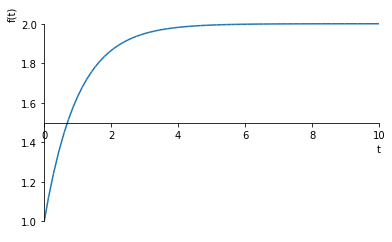

In [43]:
sympy.plot(solution.rhs.subs({C1: constants[0]}), (t, 0, 10))

### Numeric solution

When the boundary conditions of differential equations are specified at $t=0$, this is known as an [Initial Value Problem](https://en.wikipedia.org/wiki/Initial_value_problem) or IVP. We can solve such problems numerically using `scipy.integrate.solve_ivp`.

In [44]:
import scipy.integrate

In [45]:
Fin = 2

In [46]:
def dhdt(t, h):
    """Function returning derivative of h - note it takes t and h as arguments"""
    Fout = K*h
    return 1/A*(Fin - Fout)

`solve_ivp` will automatically determine the time steps to use, integrating between the two points in `tspan`:

In [47]:
tspan = (0, 10)

In [48]:
sol = scipy.integrate.solve_ivp(dhdt, tspan, [h0])

We'll need a smooth set of time points to evaluate the analytic solution

In [49]:
tsmooth = numpy.linspace(0, 10, 1000)
hanalytic = 2 - numpy.exp(-tsmooth)

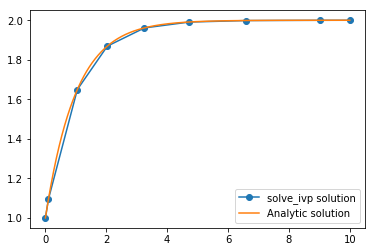

In [50]:
plt.plot(sol.t, sol.y.T, 'o-', label='solve_ivp solution')
plt.plot(tsmooth, hanalytic, label='Analytic solution')
plt.legend()

Notice that `solve_ivp` is taking really large steps but is still getting a really accurate solution. Of course, because we are taking such big steps to solve the differential equation, we now have a problem of interpolating between those points. The linear interpolation is clearly not very good, so `solve_ivp` supplies an extra argument which allows us to specify points we want the solution at. Note that this does not change the step size. The same steps are used internally and are then interpolated using a smooth function which is known to approximate the solution to the differential equation well.

In [51]:
sol = scipy.integrate.solve_ivp(dhdt, tspan, [h0], t_eval=tsmooth)

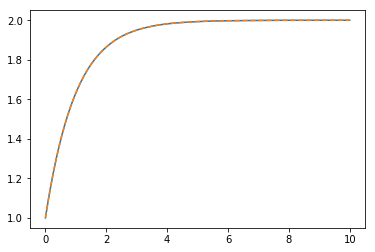

In [52]:
plt.plot(tsmooth, sol.y.T)
plt.plot(tsmooth, hanalytic, '--')

We can see that this interpolation is very close to the correct solution.

There is a problem with taking big steps if inputs change discontinuously. This example illustrates the problem:

In [53]:
import scipy.integrate

In [54]:
def Fin(t):
    """ A step which starts at t=2 """
    if t < 2:
        return 1
    else:
        return 2

In [55]:
def dhdt(t, h):
    Fout = K*h
    return 1/A*(Fin(t) - Fout)

In [56]:
tspan = (0, 10)

In [57]:
sol = scipy.integrate.solve_ivp(dhdt, tspan, [h0])
smoothsol = scipy.integrate.solve_ivp(dhdt, tspan, [h0], t_eval=tsmooth)

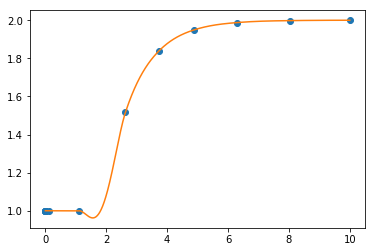

In [58]:
plt.plot(sol.t, sol.y.T, 'o')
plt.plot(smoothsol.t, smoothsol.y.T)

That downward bump in the level is a numerical anomaly due to the places where the samples are taking during integration. To make sure that we don't miss the moment when the step occurs, we can limit the step size that `solve_ivp` uses.

In [59]:
sol = scipy.integrate.solve_ivp(dhdt, tspan, [h0], max_step=0.1)
smoothsol = scipy.integrate.solve_ivp(dhdt, tspan, [h0], t_eval=tsmooth, max_step=0.1)

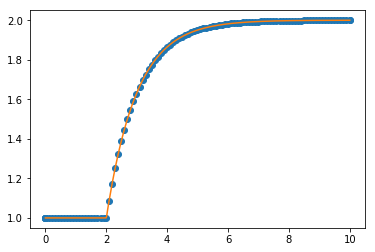

In [60]:
plt.plot(sol.t, sol.y.T, 'o')
plt.plot(smoothsol.t, smoothsol.y.T)

This works, but we pay for this with computer time:

In [61]:
%%timeit
sol = scipy.integrate.solve_ivp(dhdt, tspan, [h0])

3.09 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
%%timeit
sol = scipy.integrate.solve_ivp(dhdt, tspan, [h0], max_step=0.1)

22.3 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### A note about odeint

The default solver for ODEs in scipy used to be odeint, but this is now officially deprecated. You may still encounter it in older codes, so take note of the differences:

In [63]:
def odeintdhdt(h, t):
    """Odeint expects a function with the arguments reversed from solve_ivp"""
    return dhdt(t, h)

The order in which the initial values and the input times are specified is different. Also, unlike `solve_ivp`, you always give `odeint` the times you want the results at.

In [64]:
odeinth = scipy.integrate.odeint(odeintdhdt, h0, tsmooth)

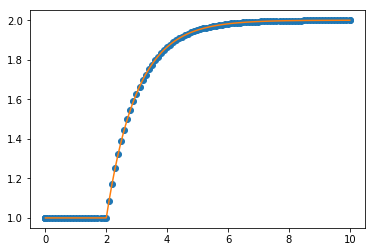

In [65]:
plt.plot(sol.t, sol.y.T, 'o')
plt.plot(tsmooth, odeinth)